In [1]:
%matplotlib notebook
import os
import numpy as np
import torch 
from torch import nn 
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Part 1

The Stanford Cars dataset root directory is created below.

In [3]:
train_dir = "images (70-30)/train"
val_dir = "images (70-30)/val"
test_dir = "images (70-30)/test"

image_size = (224,224)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_set = tv.datasets.ImageFolder(train_dir, tv.transforms.Compose([
    tv.transforms.Resize(image_size),
    tv.transforms.ToTensor(),
    normalize
    ]))

val_set = tv.datasets.ImageFolder(val_dir, tv.transforms.Compose([
    tv.transforms.Resize(image_size),
    tv.transforms.ToTensor(),
    normalize
    ]))


transform = tv.transforms.Compose([
    tv.transforms.Resize(image_size),
    tv.transforms.ToTensor(),
    normalize
    ])


<IPython.core.display.Javascript object>


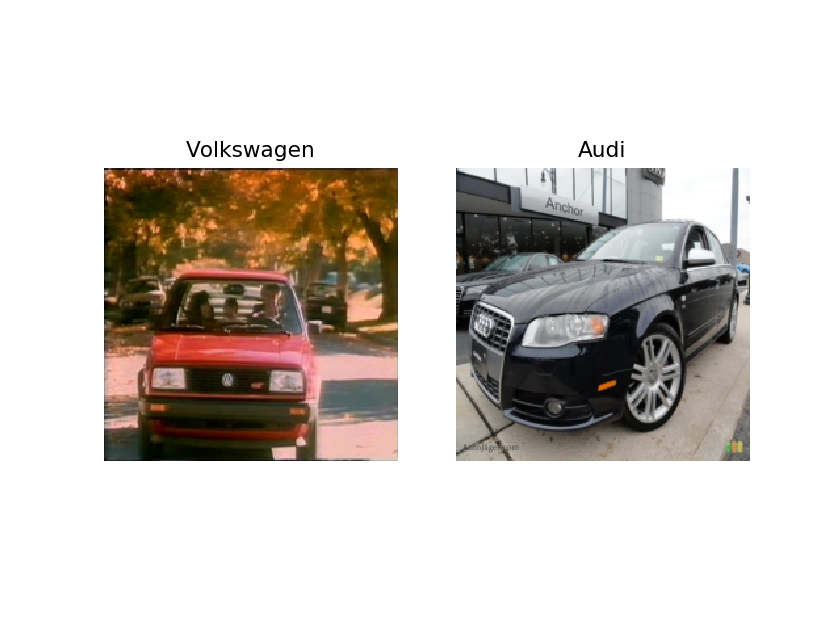

In [4]:

def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

# Visualize images:

x = train_set[10][0]
y = train_set[-1][0]
fig = plt.figure()
ax1 = fig.add_subplot(1,2,2)
myimshow(x,ax1)
plt.title("Audi")
ax2 = fig.add_subplot(1,2,1)
myimshow(y,ax2)
plt.title("Volkswagen")
plt.show()

### Part 2 - TRAINING


In [6]:
import nntools as nt
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def criterion(self, y, d):
        return self.cross_entropy(y, d)

###  With VGG16:

In [7]:
class VGG16Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        
        self.features = vgg.features
        self.classifier = vgg.classifier
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

### Stats Manager Set-up

In [8]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0
        
    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())
        
    def summarize(self):
        loss =super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss,'accuracy': accuracy}

In [12]:
lr = 1e-3
net = VGG16Transfer(num_classes=12)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)  # With adaptive lr scheduler 
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,output_dir="carclass_vgg2", perform_validation_during_training=True)

In [13]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],label="training loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],label="evaluation loss")
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],label="training accuracy")
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],label="evaluation accuracy")
    axes[0].legend()
    axes[1].legend()
    axes[0].set_xlabel("Epoch")
    axes[1].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[1].set_ylabel("Accuracy")
    
    plt.tight_layout()
    fig.canvas.draw()

<IPython.core.display.Javascript object>


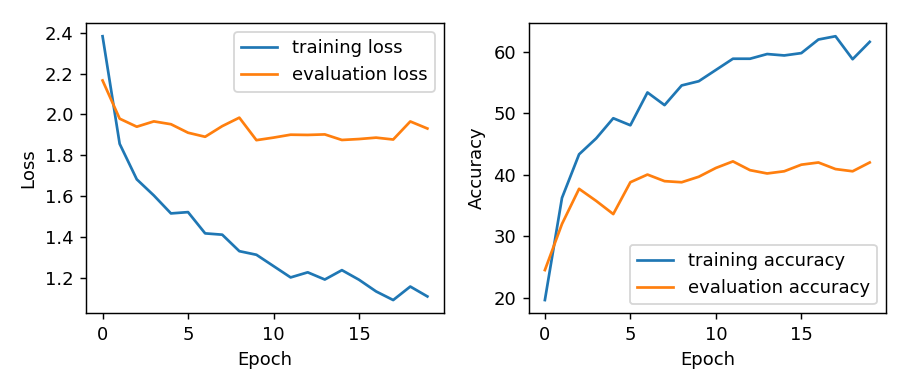

Start/Continue training from epoch 0
Epoch 1 (Time: 61.84s)
Epoch 2 (Time: 61.60s)
Epoch 3 (Time: 61.60s)
Epoch 4 (Time: 61.78s)
Epoch 5 (Time: 61.31s)
Epoch 6 (Time: 61.73s)
Epoch 7 (Time: 61.42s)
Epoch 8 (Time: 61.76s)
Epoch 9 (Time: 61.89s)
Epoch 10 (Time: 61.78s)
Epoch 11 (Time: 61.62s)
Epoch 12 (Time: 61.27s)
Epoch 13 (Time: 61.61s)
Epoch 14 (Time: 61.49s)
Epoch 15 (Time: 61.61s)
Epoch 16 (Time: 61.51s)
Epoch 17 (Time: 61.62s)
Epoch 18 (Time: 61.63s)
Epoch 19 (Time: 61.75s)
Epoch 20 (Time: 61.52s)
Finish training for 20 epochs


In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

## With Resnet18 Model:

In [64]:
class Resnet18Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(Resnet18Transfer, self).__init__()
        resnet = tv.models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = fine_tuning
        
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.pool1 = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.pool2 = resnet.avgpool
        num_ftrs = resnet.fc.in_features
        self.fc = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        y = self.fc(x)
        return y

In [173]:
lr = 1e-3
net2 = Resnet18Transfer(num_classes=12)
net2 = net2.to(device)
adam = torch.optim.Adam(net2.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp2 = nt.Experiment(net2, train_set, val_set, adam, stats_manager,output_dir="carclass1_resnet", batch_size=12, perform_validation_during_training=True)

<IPython.core.display.Javascript object>


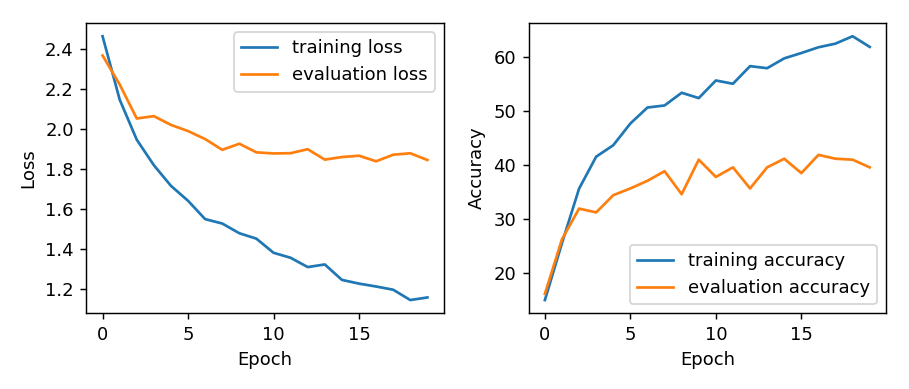

Start/Continue training from epoch 0
Epoch 1 (Time: 36.56s)
Epoch 2 (Time: 36.80s)
Epoch 3 (Time: 35.44s)
Epoch 4 (Time: 35.34s)
Epoch 5 (Time: 35.61s)
Epoch 6 (Time: 35.79s)
Epoch 7 (Time: 36.00s)
Epoch 8 (Time: 35.52s)
Epoch 9 (Time: 35.25s)
Epoch 10 (Time: 35.60s)
Epoch 11 (Time: 35.55s)
Epoch 12 (Time: 35.44s)
Epoch 13 (Time: 35.55s)
Epoch 14 (Time: 35.60s)
Epoch 15 (Time: 35.50s)
Epoch 16 (Time: 35.29s)
Epoch 17 (Time: 35.47s)
Epoch 18 (Time: 35.31s)
Epoch 19 (Time: 35.60s)
Epoch 20 (Time: 35.56s)
Finish training for 20 epochs


In [174]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

# TEST

<IPython.core.display.Javascript object>


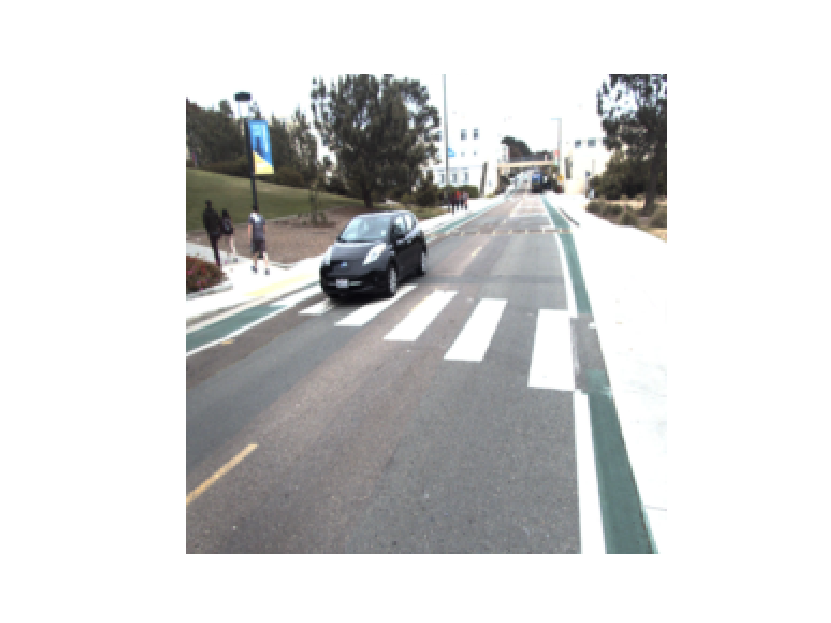

In [222]:

test_imgs = []
for i in range(12):
    img_addr = "images (70-30)/test/*.png"
    img_addr = img_addr.replace("*", str(i+1))
    test_img = Image.open(img_addr).convert('RGB')
    test_imgs.append(transform(test_img))

new = transform(test_img)
plt.figure()
myimshow(new)
plt.show()

In [262]:
output = net.forward(test_imgs[10].unsqueeze(0).cuda())  # vgg
labels = ["Audi", "BMW", "Chevrolet", "Dodge", "Ford", "GMC", "Honda", "Hyundai", "Mercedes-Benz", "Nissan", "Toyota", "Volkswagen"]
idx = output.argmax()
print("The detected vehicle is of Make: ", labels[idx])
print(output, idx)


The detected vehicle is of Make:  BMW
tensor([[-6.0388, -4.3730, -6.2114, -6.1129, -5.8309, -8.9795, -8.9494, -7.7569,
         -8.5895, -9.0692, -8.2453, -9.0151]], device='cuda:0',
       grad_fn=<AddmmBackward>) tensor(1, device='cuda:0')


In [255]:
output2 = net2.forward(test_imgs[10].unsqueeze(0).cuda())  # resnet
idx = output2.argmax()
print("The detected vehicle is of Make: ", labels[idx])

The detected vehicle is of Make:  Ford


### Performance comparison: 

In [263]:
print("For adaptive learning")
vgg_eval = exp1.evaluate()
resnet_eval = exp2.evaluate()
print("Evaluation for VGG: {}".format(vgg_eval))
print("Evaluation for Resnet: {}".format(resnet_eval))

For adaptive learning
Evaluation for VGG: {'accuracy': tensor(22.1429, device='cuda:0'), 'loss': 3.1081764357430592}
Evaluation for Resnet: {'accuracy': tensor(19.6809, device='cuda:0'), 'loss': 2.9130249441938196}
